# FIT5201_2018S2 Assignment 1 - Section F - Question 7

- <font color='blue'>**Student Id**</font>: 27771539
- <font color='blue'>**Student Name**</font>: Chuangfu Xie
- <font color='blue'>**Packages in use**</font>:
    - `repr`: Provide more control on graphical presentation
    - `ggplot2`: Data visualization package
    - `reshape2`: reshape data

# Logistic Regression vs. Bayesian Classifier

## 0. Import packages

In [34]:
library(repr)
library(ggplot2)
library(reshape2)

### 0.1 Load CSV

In [22]:
train <- read.csv('./datasets//Task1E_train.csv')
test <- read.csv('./datasets//Task1E_test.csv')

## 1. BC vs LR

### 1.1 Fit BC

In [23]:
# Setting
c0 <- '1'; c1 <- '-1'
for.loop <- seq(5,nrow(train),5)
Error <- data.frame(matrix(0, nrow=length(for.loop), ncol=3))
names(Error) <- c('size',"test","train")
Error$size <- for.loop

# Fitting
for (i in for.loop){
    
    train.len <- i # incremental by 5
    train.index <- seq(1:train.len)
    
    #Prepare data
    train.data <- train[train.index, c('x1', 'x2')]
    train.label <- train[train.index, 'y']
    test.data <- test[train.index, c('x1', 'x2')]
    test.label <- test[train.index, 'y']
    
    # Class probabilities:
    p0.hat <- sum(train.label==c0)/nrow(train.data) # P(c0)
    p1.hat <- 1 - p1.hat
    
    # Class means:
    mu0.hat <- colMeans(train.data[train.label==c0,])
    mu1.hat <- colMeans(train.data[train.label==c1,])
    
    # class covariance matrices:
    sigma0.hat <- var(train.data[train.label==c0,])
    sigma1.hat <- var(train.data[train.label==c1,])

    # shared covariance matrix:
    sigma.hat <- p0.hat * sigma0.hat + p1.hat * sigma1.hat 
    
    # calculate posteriors:
    posterior0 <- p0.hat*dmvnorm(x=train.data, mean=mu0.hat, sigma=sigma.hat)
    posterior1 <- p1.hat*dmvnorm(x=train.data, mean=mu1.hat, sigma=sigma.hat)
    
    # calculate predictions:
    train.predict <- ifelse(posterior0 > posterior1, c0, c1)
    test.predict <- ifelse(p0.hat*dmvnorm(x=test.data, mean=mu0.hat, sigma=sigma.hat) > p1.hat*dmvnorm(x=test.data, mean=mu1.hat, sigma=sigma.hat), c0, c1)

    #store in accuracy table
    Error[i/5,][3] <-  100-(sum(train.label==train.predict)/nrow(train.data)*100)
    Error[i/5,][2] <-  100-(sum(test.label==test.predict)/nrow(test.data)*100)
}

### 1.2 Plot BC error

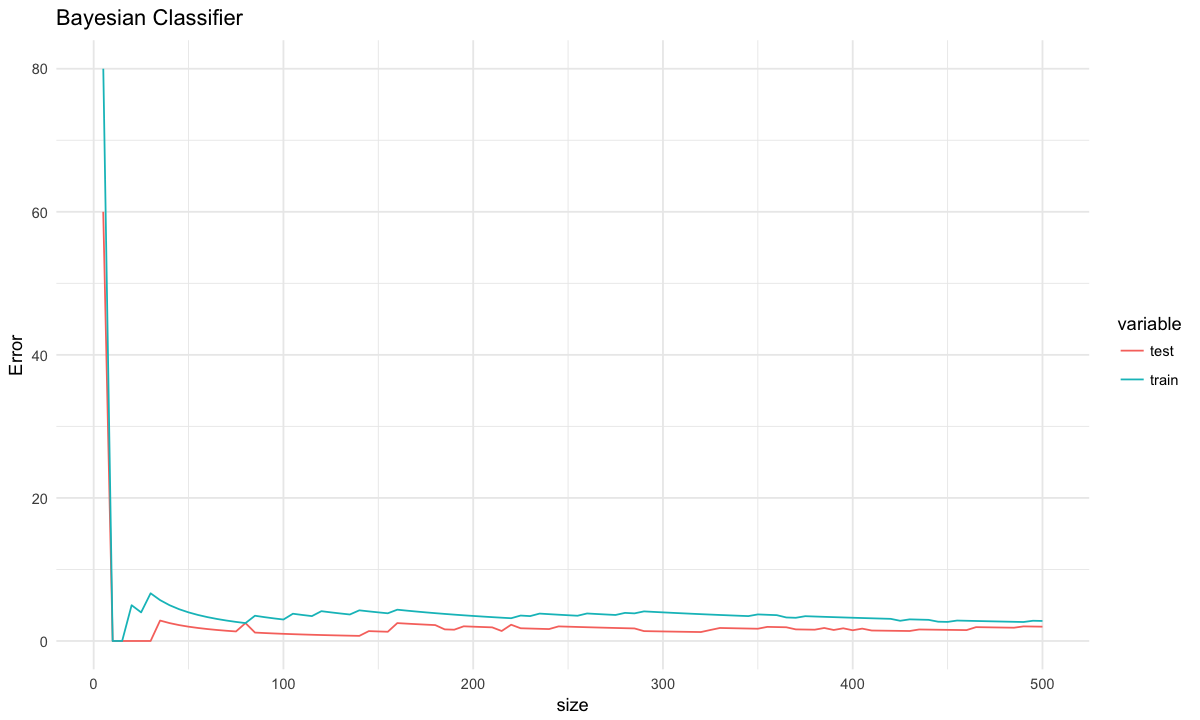

In [35]:
bc_data <- melt(Error, id='size')
options(repr.plot.width=10, repr.plot.height=6, warn=-1)
ggplot(data=bc_data, aes(x=size, y=value, color=variable)) + geom_line() + 
        labs(title='Bayesian Classifier', y='Error') +  theme_minimal()

### 1.3 Fit LR

#### 1.3.1 Auxiliary function

In [ ]:
# predicts class labels
predict <- function(w, X, c0, c1){
    sig <- sigmoid(w, X)
    return(ifelse(sig>0.5, c1,c0))
}
    
# cost function
cost <- function (w, X, T, c0){
    sig <- sigmoid(w, X)
    return(sum(ifelse(T==c0, 1-sig, sig)))
}

# Sigmoid function
sigmoid <- function(w, x){
    return(1.0/(1.0+exp(-w%*%t(cbind(1,x)))))    
}

# For record error
LR_Error <- data.frame(matrix(0,nrow=length(for.loop), ncol=3))
names(LR_Error) <- c('size',"test","train")
LR_Error$size <- for.loop

#### 1.3.2 Fitting

In [27]:
# Start fitting
for (i in for.loop){
    #print (i)
    train.len <- i
    train.index <- seq(1:train.len)
    
    #prepare data
    train.data <- train[train.index, c('x1', 'x2')]
    train.label <- train[train.index, 'y']
    test.data <- test[train.index, c('x1', 'x2')]
    test.label <- test[train.index, 'y']
    
    # Initializations
    tau.max <- 1500 
    eta <- 0.01
    epsilon <- 0.01
    tau <- 1
    terminate <- FALSE

    ## Just a few name/type conversion to make the rest of the code easy to follow
    X <- as.matrix(train.data) # rename just for conviniance
    T <- ifelse(train.label==c0,0,1) # rename just for conviniance

    W <- matrix(,nrow=tau.max, ncol=(ncol(X)+1)) # empty matrix
    W[1,] <- runif(ncol(W)) #starting weight
    Y <- sigmoid(W[1,],X)
    
    # record cost
    costs <- data.frame('tau'=1:tau.max)
    costs[1, 'cost'] <- cost(W[1,],X,T, c0)
    
    
    while(!terminate){
    # check termination criteria:
        terminate <- tau >= tau.max | cost(W[tau,],X,T, c0)<=epsilon

        # shuffle data:
        train.index <- sample(1:train.len, train.len, replace = FALSE)
        X <- X[train.index,]
        T <- T[train.index]

        # for each datapoint:
        for (i in 1:train.len){
            # check termination criteria:
            if (tau >= tau.max | cost(W[tau,],X,T, c0) <=epsilon) {terminate<-TRUE;break}

            Y <- sigmoid(W[tau,],X)
            # Update the weights
            W[(tau+1),] <- W[tau,] - eta * (Y[i]-T[i]) * cbind(1, t(X[i,]))
            # record the cost:
            costs[(tau+1), 'cost'] <- cost(W[tau,],X,T, c0)
            # update the counter:
            tau <- tau + 1
            # Schedule decrease in learning rate:
            eta = eta * 0.999
        }
    }
    
    costs <- costs[1:tau, ] # in case of early stop
    w <- W[tau,]
    
    # store test error
    LR_Error[i/5,][3] <- table(unlist(factor(predict(w,train.data,c0,c1)==train.label)))[1]/train.len *100
    LR_Error[i/5,][2] <- table(unlist(factor(predict(w,test.data,c0,c1)==test.label)))[1]/train.len *100
}

### 1.4 Plot LR error

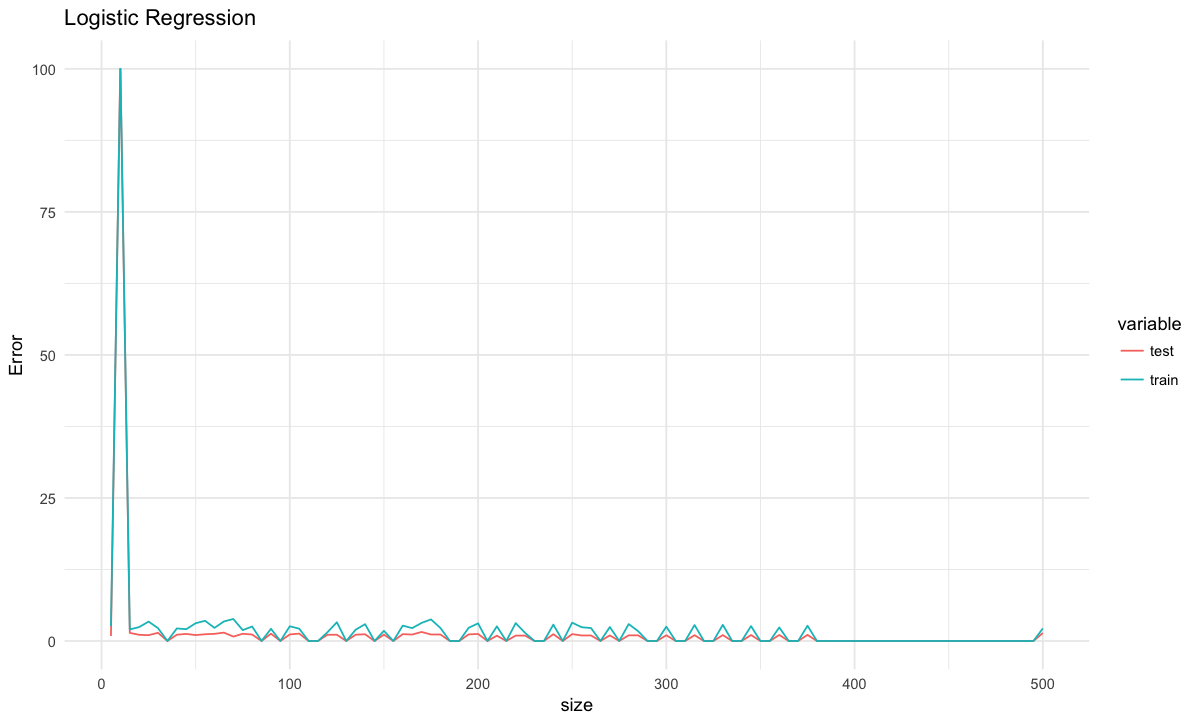

In [36]:
lr_data <- melt(LR_Error, id='size')
ggplot(data=lr_data, aes(x=size, y=value, color=variable)) + geom_line() + 
        labs(title='Logistic Regression', y='Error') +  theme_minimal()

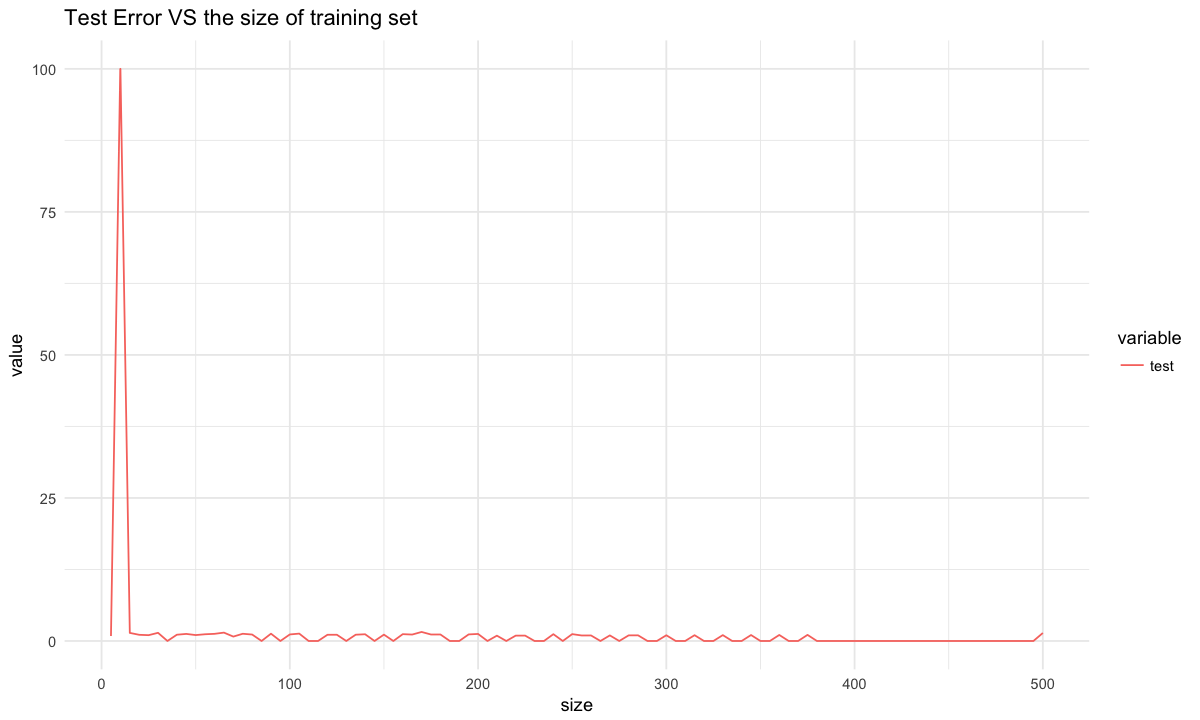

In [37]:
data <- as.data.frame(cbind(Error[1],LR_Error[2],Error[2]))
data.m <- melt(data, id='size')
ggplot(data=data.m, aes(x=size, y=value, color=variable)) + geom_line() + 
        labs(title='Test Error VS the size of training set') +  theme_minimal()

## 2. Report

**Answer for Qa**:  
The more training data we fit, the smaller the test error we can have. By compare the graph, we can find that LR is better than BC as it has smaller test error (closer to 0).

**Answer for Qb**:  
BC suits for small training dataset. LR suits for big training dataset. 

**Answer for Qc**:  
**BC**: The reason why it suits for small training dataset is that it estimates joint probability based on the distribution of the training data. Even the training dataset can't see the 'big picture' of the ensemble, it still perform well based on Bayes' theorem, but may also suffer from it having higher test error
**LR**: Since the number of training dataset is large, it estimates directly from the training data and can see the 'big picture' of the ensemble, having a lower test error. However, if the size of training dataset is samll, the 'big picture' of the ensemble might be biased, it will make our fitting becomes underfitting resulting in high error.